Inception code from https://github.com/ieee8023/NeuralNetwork-Examples/

In [1]:
import theano, theano.tensor as T
import numpy as np, matplotlib.pyplot as plt
import os, time, random, sys
notebook_start_time = time.time()

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.8.2.dev-RELEASE
lasagne 0.2.dev1


In [2]:
input_var = T.tensor4('inputs')

input_shape = (None, 3, 32, 32)
network = InputLayer(shape=input_shape, input_var=input_var)

# from MXNet 
def ConvFactory(data, num_filter, filter_size, stride=(1,1), pad=(0, 0)):
    data = BatchNormLayer(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def DownsampleFactory(data, ch_3x3):
    conv = ConvFactory(data=data, filter_size=(3, 3), stride=(2, 2), num_filter=ch_3x3, pad=(1, 1))
    pool = Pool2DLayer(data, pool_size=3, stride=(2, 2), pad=(1, 1), mode='max')
    concat = ConcatLayer([conv, pool])
    return concat

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = ConvFactory(data=data, filter_size=(1, 1), pad=(0, 0), num_filter=ch_1x1)
    conv3x3 = ConvFactory(data=data, filter_size=(3, 3), pad=(1, 1), num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat
        
def get_symbol(network, num_classes = 10):
    conv1 = ConvFactory(data=network, filter_size=(3,3), pad=(1,1), num_filter=96)
    in3a = SimpleFactory(conv1, 32, 32)
    in3b = SimpleFactory(in3a, 32, 48)
    in3c = DownsampleFactory(in3b, 80)
    in4a = SimpleFactory(in3c, 112, 48)
    in4b = SimpleFactory(in4a, 96, 64)
    in4c = SimpleFactory(in4b, 80, 80)
    in4d = SimpleFactory(in4c, 48, 96)
    in4e = DownsampleFactory(in4d, 96)
    in5a = SimpleFactory(in4e, 176, 160)
    in5b = SimpleFactory(in5a, 176, 160)
    pool = Pool2DLayer(in5b, pool_size=7, stride=1, pad=1, mode='average_exc_pad')
    
    flatten = FlattenLayer(pool)
    dense = DenseLayer(flatten, num_units=num_classes, nonlinearity=lasagne.nonlinearities.rectify)
    out = DenseLayer(dense, num_units=num_classes, nonlinearity=lasagne.nonlinearities.softmax)
    
    return out

network = get_symbol(network)

In [3]:
output_shape = lasagne.layers.get_output_shape(network)
print "input_shape:",input_shape,"-> output_shape:",output_shape
sys.stdout.flush()

input_shape: (None, 3, 32, 32) -> output_shape: (None, 10)


In [4]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]


def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """
    import pydotplus as pydot
    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        key = repr(layer)
        label = layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph


def draw_to_notebook(layers, **kwargs):
    """
    Draws a network diagram in an IPython notebook
    :parameters:
        - layers : list or NeuralNet instance
            List of layers or the neural net to draw.
        - **kwargs : see the docstring of make_pydot_graph for other options
    """
    from IPython.display import Image
    layers = (layers.get_all_layers() if hasattr(layers, 'get_all_layers')
              else layers)
    dot = make_pydot_graph(layers, **kwargs)
    return Image(dot.create_png())

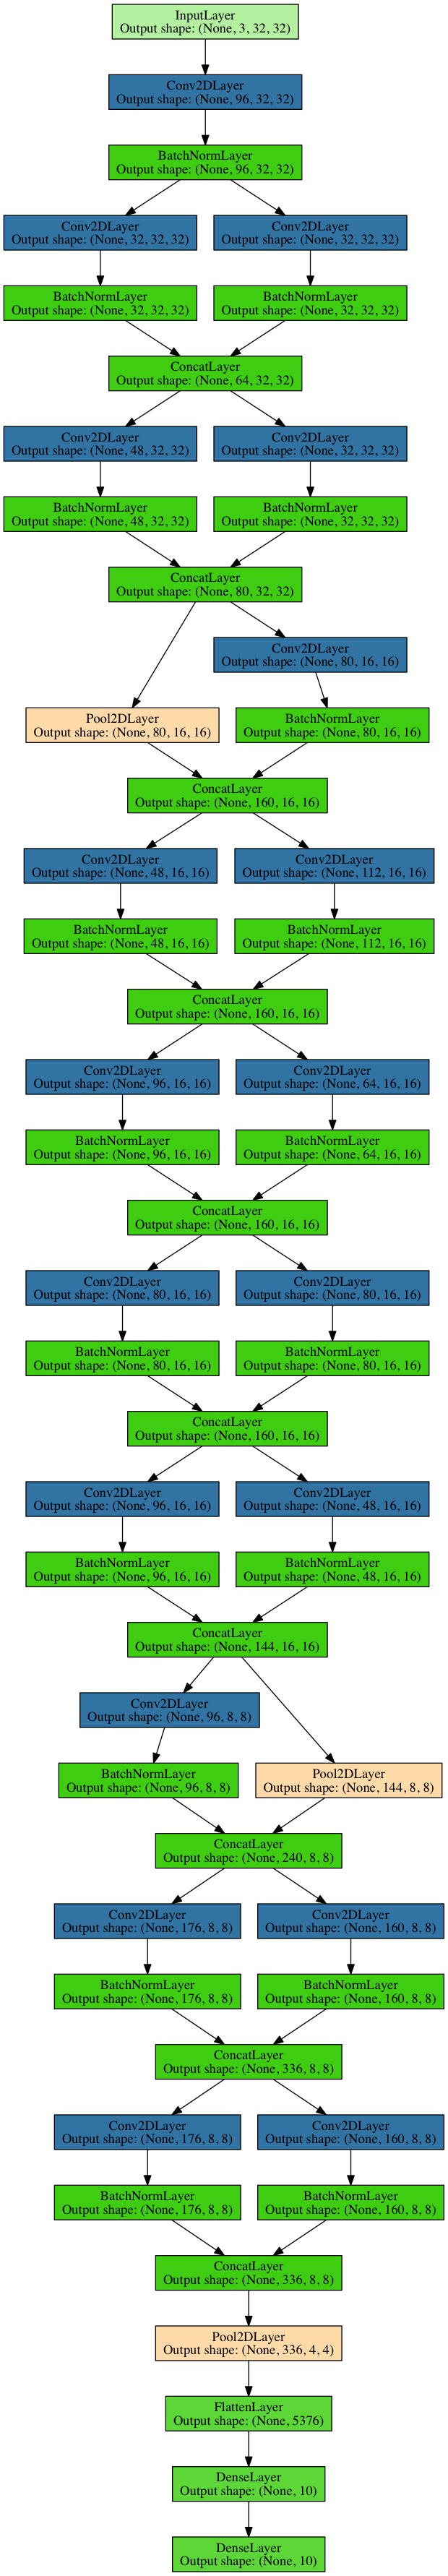

In [5]:
draw_to_notebook(lasagne.layers.get_all_layers([network]))